Changes:

* Subsetting to genes that are present in all data sources.. array, RNA-seq, and TEMPUS. 10363 genes.
* Subsetting the JIVE gene signatures to those present genes.

Questions: Are there missing genes, in array, that are present in RNA-seq, that would be better to have for TEMPUS?




In [1]:
#devtools::install_github("gibbsdavidl/robencla", force = T)

In [2]:
library(tidyverse)
library(robencla)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: R6

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: xgboost


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: plotROC

Loading required package: parallel

Loading required package: ROCit



In [3]:
dat.m <- read_csv('data/Males_Array_Data_CW.csv')
load("data/Males_feature_sel_genelist.rda")
# removing signature genes that are not available in our data sets
male.jive.gene.list <- readRDS("data/Males_jive_cluster_genes_CW.rds") %>% dplyr::filter(value %in% colnames(dat.m))

Rows: 220 Columns: 10356
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr     (2): sample, cluster.group
dbl (10354): PDIA2, ZNF195, PIK3C2B, PHB2, SERF2, PLEKHG6, HOXA9, CD2AP, AP3...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
table(dat.m$cluster.group)


cluster1 cluster2 cluster3 cluster4 cluster5 
      38       85       35       26       36 

In [5]:
genelist

[1] "NTRK2"    "POSTN"    "TMEM43"   "JAG1"     "POSTN"    "MAN1C1"  
 [7] "CIT"      "POLR1B"   "HSPB8"    "POSTN"    "MID1IP1"  "ZCCHC10" 
[13] "BBOX1"    "RCAN1"    "TMEM43"   "JAG1"     "IBSP"     "PPARGC1A"
[19] "CIT"      "POLR1B"   "TPM4"     "C1D"      "MID1IP1"  "ZCCHC10" 
[25] "TPM4"     "IFI44L"   "TMEM43"   "JAG1"     "METTL3"   "IFI44L"  
[31] "CIT"      "POLR1B"   "RSAD2"    "GSK3A"    "MID1IP1"  "ZCCHC10" 
[37] "DNAJC7"   "PRKRIP1"  "TMEM43"   "JAG1"     "MAP3K7"   "ZNF512B" 
[43] "CIT"      "POLR1B"   "DNAJC7"   "LARS2"    "MID1IP1"  "ZCCHC10" 
[49] "NDC80"    "CRYM"     "TMEM43"   "JAG1"     "CRYM"     "KIF20A"  
[55] "CIT"      "POLR1B"   "CCK"      "TTK"      "MID1IP1"  "ZCCHC10"

In [6]:
dim(dat.m)

[1]   220 10356

In [7]:
genelist_m <- genelist

sigs.m <- list("C1"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster1'],
               "C2"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster2'],
               "C3"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster3'],
               "C4"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster4'],
               "C5"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster5']
)

# our classifier object named Anne.
anne <- Robencla$new("Anne")

# xgboost parameters to pass to each sub-classifier in the ensembles
params <- list(max_depth=12,    # "height" of the tree, 6 is actually default. I think about 12 seems better.  (xgboost parameter)
               eta=0.2,        # this is the learning rate. smaller values slow it down, more conservative   (xgboost parameter)
               nrounds=24,     # number of rounds of training, lower numbers less overfitting (potentially)  (xgboost parameter)
               nthreads=4,     # parallel threads
               gamma=0.2,        # Minimum loss reduction required to again partition a leaf node. higher number ~ more conservative (xgboost parameter)
               lambda=1.2,     # L2 regularization term on weights, higher number ~ more conservative (xgboost parameter)
               alpha=0.2,     # L1 regularization term on weights. higher number ~ more conservative (xgboost parameter)
               verbose=0,
               train_perc=0.8,
               combine_function='median',
               size=11
)

In [8]:
# First we use the training data
anne$autocv(data_frame=dat.m,
            label_name='cluster_group',
            sample_id = 'sample',
            data_mode=c('pairs','quartiles'), # pairs,allpairs,sigpairs,quartiles,tertiles,binarize,ranks,original #
            signatures=NULL,
            pair_list=genelist,  # subset to these genes.
            params=params,
            cv_rounds=10
            )


[1] "*** Training-Testing Round 1 ***"
[1] "*** Training-Testing Round 2 ***"
[1] "*** Training-Testing Round 3 ***"
[1] "*** Training-Testing Round 4 ***"
[1] "*** Training-Testing Round 5 ***"
[1] "*** Training-Testing Round 6 ***"
[1] "*** Training-Testing Round 7 ***"
[1] "*** Training-Testing Round 8 ***"
[1] "*** Training-Testing Round 9 ***"
[1] "*** Training-Testing Round 10 ***"


In [9]:
df.m <- anne$cv_results
df.m$cluster1 <- as.numeric(df.m$cluster1)
df.m$cluster2 <- as.numeric(df.m$cluster2)
df.m$cluster3 <- as.numeric(df.m$cluster3)
df.m$cluster4 <- as.numeric(df.m$cluster4)
df.m$cluster5 <- as.numeric(df.m$cluster5)
head(df.m)

write.table(as.data.frame(df.m), 'results/male_cv_pairs_quartiles.csv', sep=',', quote = F, row.names = F)

,SampleIDs,BestCalls,cluster2,cluster1,cluster5,cluster3,cluster4,Label
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
TCGA-06-0750-01,TCGA-06-0750-01,cluster1,0.41736368,0.01274924,0.11657940,0.01392180,0.439385882,cluster4
TCGA-02-0033-01,TCGA-02-0033-01,cluster1,0.06898285,0.66752150,0.16095576,0.09326693,0.009272960,cluster1
TCGA-06-0156-01,TCGA-06-0156-01,cluster2,0.93440309,0.01880087,0.01052964,0.01166922,0.024597169,cluster2
TCGA-08-0351-01,TCGA-08-0351-01,cluster5,0.01972262,0.01141812,0.80522028,0.15391829,0.009720695,cluster5
TCGA-14-0865-01,TCGA-14-0865-01,cluster5,0.80256782,0.10289060,0.03897511,0.03409055,0.021475911,cluster2
TCGA-02-0321-01,TCGA-02-0321-01,cluster2,0.93676448,0.01021528,0.01109663,0.01256049,0.029363113,cluster2


In [10]:
table(Pred=df.m$BestCalls, True=df.m$Label)

          True
Pred       cluster1 cluster2 cluster3 cluster4 cluster5
  cluster1       29        2        1        5        2
  cluster2        3       80        3        3        2
  cluster3        3        1       27        0        1
  cluster4        1        1        0       14        1
  cluster5        2        1        4        4       30

In [11]:
anne$classification_metrics()

,Label,Accuracy,Sensitivity,Specificity,Precision,F1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cluster1,cluster1,0.8181818,0.7631579,0.9450549,0.7435897,0.7532468
cluster2,cluster2,0.8181818,0.9411765,0.9185185,0.8791209,0.9090909
cluster3,cluster3,0.8181818,0.7714286,0.9729730,0.8437500,0.8059701
cluster4,cluster4,0.8181818,0.5384615,0.9845361,0.8235294,0.6511628
cluster5,cluster5,0.8181818,0.8333333,0.9402174,0.7317073,0.7792208
Average,Average,0.8181818,0.7695116,0.9522600,0.8043395,0.7797383


In [12]:

imp_list <- anne$importance()

save(imp_list, file='results/male_cv_pairs_quartiles_importance.rda')


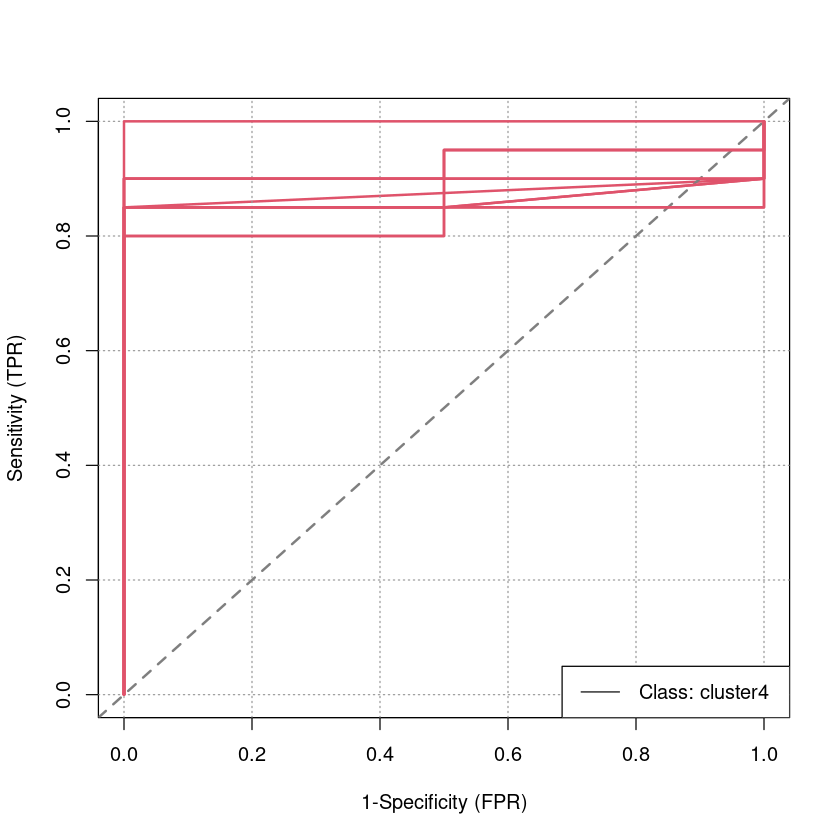

In [13]:
#ensemble_rocs(anne)
plot_roc(anne, 1, flip=T)

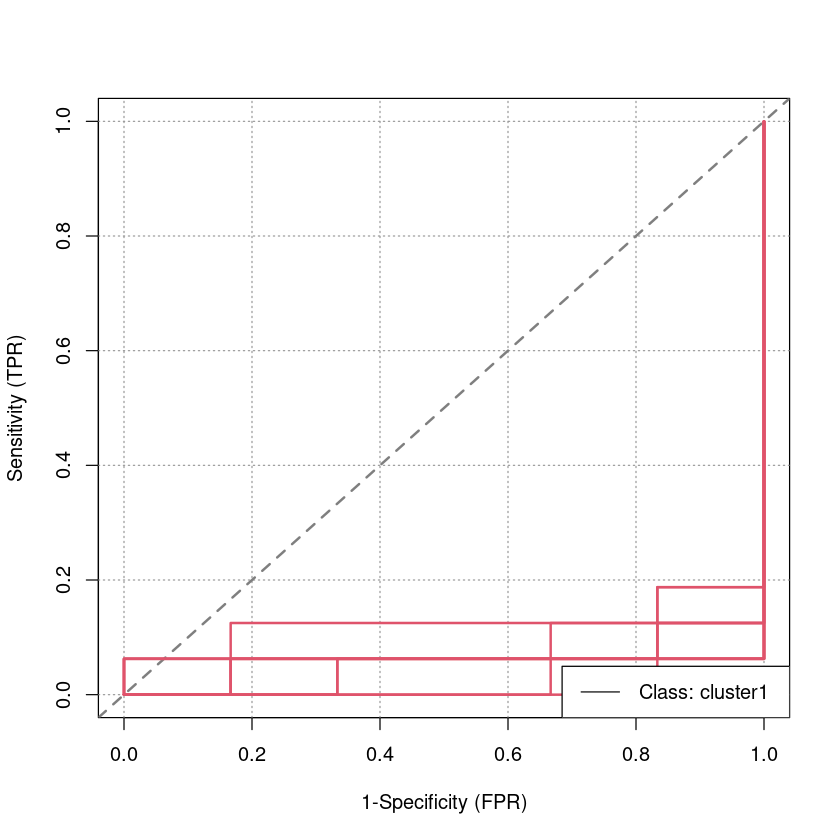

In [14]:
#ensemble_rocs(anne)
plot_roc(anne, 2, flip=T)

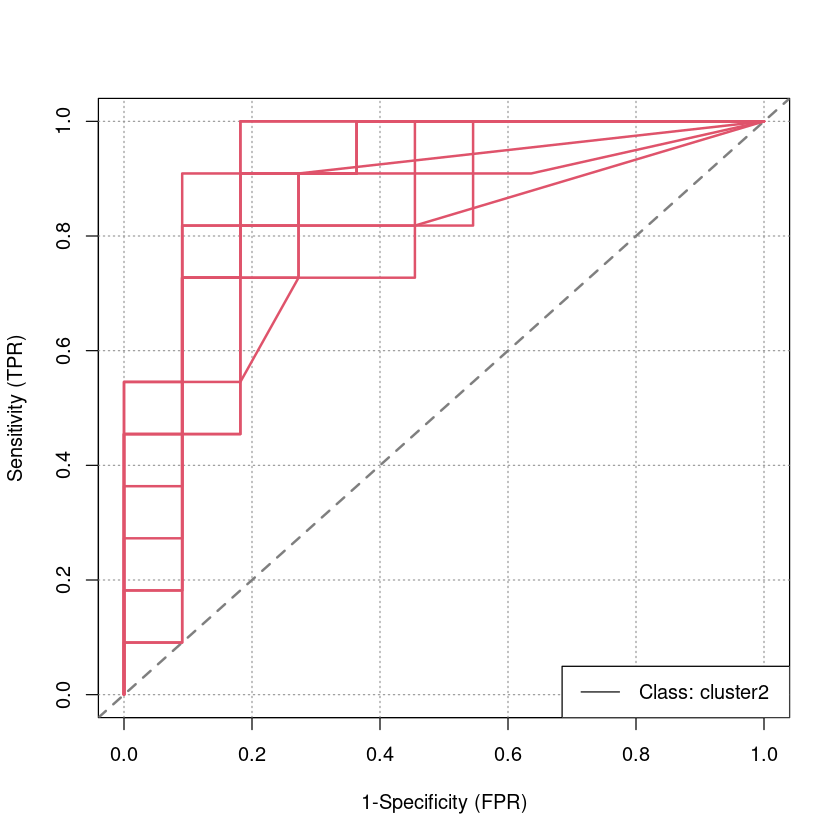

In [15]:
#ensemble_rocs(anne)
plot_roc(anne, 3, flip=T)

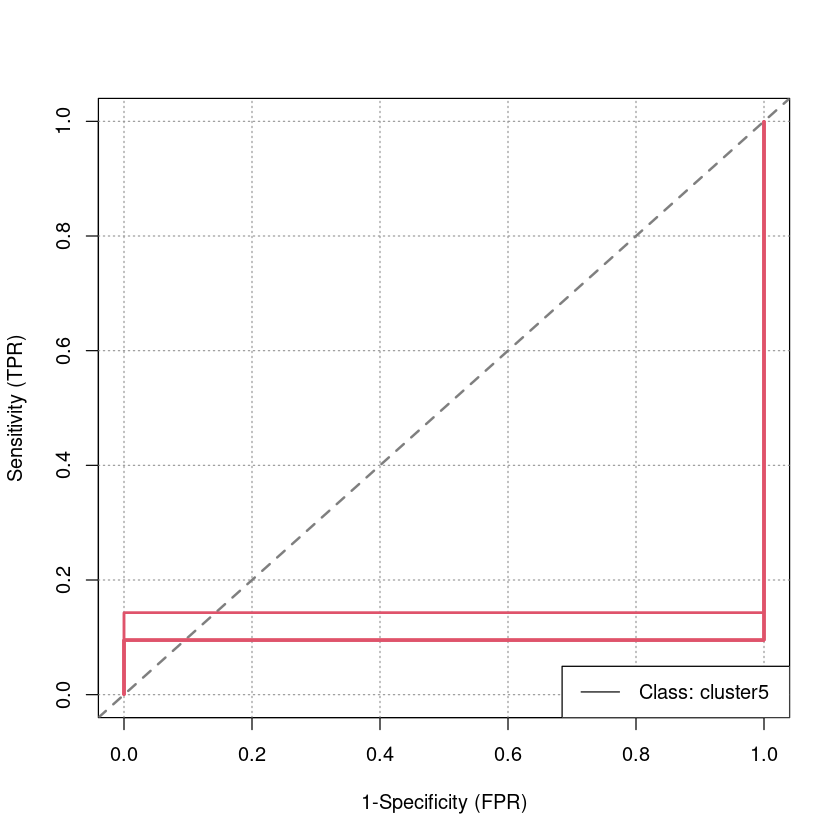

In [16]:
#ensemble_rocs(anne)
plot_roc(anne, 4, flip=T)

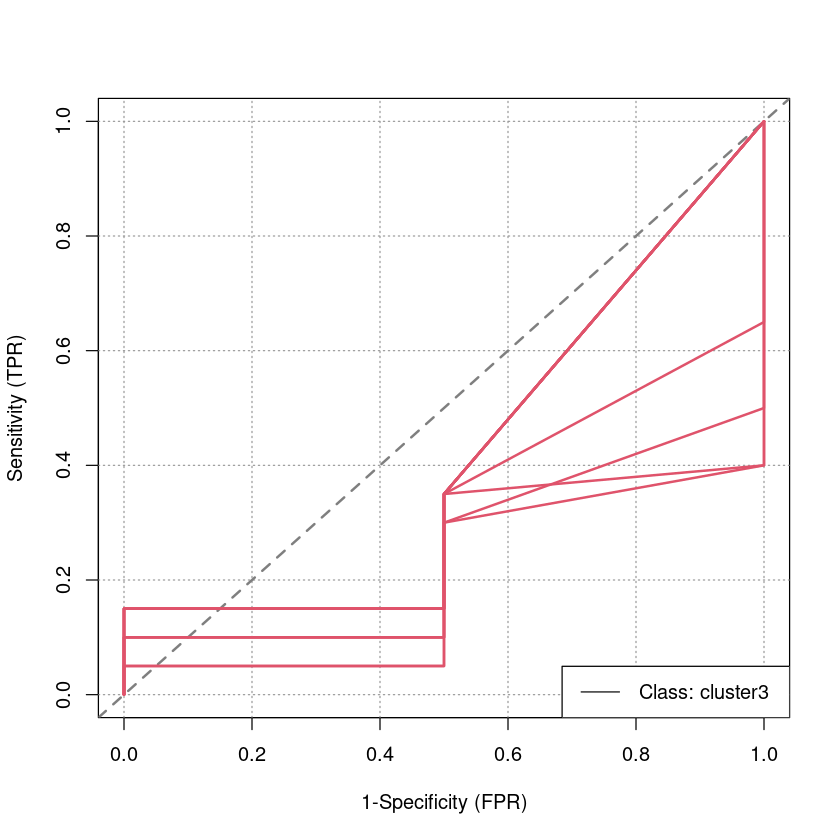

In [17]:
#ensemble_rocs(anne)
plot_roc(anne, 5, flip=T)

In [18]:
### FEMALES ###

In [19]:
dat.f <- read_csv('data/Females_Array_Data_CW.csv')
load('data/Females_feature_sel_genelist.rda')
genelist_f <- genelist
# removing signature genes that are not available in our data sets
female.jive.gene.list <- readRDS("data/Female_jive_cluster_genes_CW.rds") %>% dplyr::filter(value %in% colnames(dat.f))

Rows: 140 Columns: 10356
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr     (2): sample, cluster.group
dbl (10354): PDIA2, ZNF195, PIK3C2B, PHB2, SERF2, PLEKHG6, HOXA9, CD2AP, AP3...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [20]:
table(dat.f$cluster.group)


cluster1 cluster2 cluster3 cluster4 cluster5 
      41       24       14       21       40 

In [21]:
length(genelist)

[1] 60

In [22]:
genelist_f <- genelist

sigs_f <- list("C1"=female.jive.gene.list$value[female.jive.gene.list$cluster.group == 'cluster1'],
               "C2"=female.jive.gene.list$value[female.jive.gene.list$cluster.group == 'cluster2'],
               "C3"=female.jive.gene.list$value[female.jive.gene.list$cluster.group == 'cluster3'],
               "C4"=female.jive.gene.list$value[female.jive.gene.list$cluster.group == 'cluster4'],
               "C5"=female.jive.gene.list$value[female.jive.gene.list$cluster.group == 'cluster5']
)


# our classifier object named Roberta
buffy <- Robencla$new("buffy")

# xgboost parameters to pass to each sub-classifier in the ensembles
params <- list(max_depth=12,    # "height" of the tree, 6 is actually default. I think about 12 seems better.  (xgboost parameter)
               eta=0.2,        # this is the learning rate. smaller values slow it down, more conservative   (xgboost parameter)
               nrounds=24,     # number of rounds of training, lower numbers less overfitting (potentially)  (xgboost parameter)
               nthreads=4,     # parallel threads
               gamma=0.2,        # Minimum loss reduction required to again partition a leaf node. higher number ~ more conservative (xgboost parameter)
               lambda=1.2,     # L2 regularization term on weights, higher number ~ more conservative (xgboost parameter)
               alpha=0.2,     # L1 regularization term on weights. higher number ~ more conservative (xgboost parameter)
               verbose=0,
               train_perc=0.8,
               combine_function='median',
               size=11
)

In [23]:

# First we use the training data
buffy$autocv(data_file='data/Females_Array_Data_CW.csv',
               label_name='cluster.group',
               sample_id = 'sample',
               data_mode=c('pairs', 'quartiles'), # pairs,sigpairs,quartiles,tertiles,binarize,ranks,original #
               signatures=NULL,
               pair_list=genelist_f,  # subset to these genes.
               params=params,
               cv_rounds=10
              )



[1] "*** Training-Testing Round 1 ***"
[1] "*** Training-Testing Round 2 ***"
[1] "*** Training-Testing Round 3 ***"
[1] "*** Training-Testing Round 4 ***"
[1] "*** Training-Testing Round 5 ***"
[1] "*** Training-Testing Round 6 ***"
[1] "*** Training-Testing Round 7 ***"
[1] "*** Training-Testing Round 8 ***"
[1] "*** Training-Testing Round 9 ***"
[1] "*** Training-Testing Round 10 ***"


In [24]:
df.f <- buffy$cv_results
df.f$cluster1 <- as.numeric(df.f$cluster1)
df.f$cluster2 <- as.numeric(df.f$cluster2)
df.f$cluster3 <- as.numeric(df.f$cluster3)
df.f$cluster4 <- as.numeric(df.f$cluster4)
df.f$cluster5 <- as.numeric(df.f$cluster5)
head(df.f)

write.table(as.data.frame(df.f), 'results/female_cv_pairs_quartiles.csv', sep=',', quote = F, row.names = F)

,SampleIDs,BestCalls,cluster1,cluster5,cluster4,cluster2,cluster3,Label
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
TCGA-76-4934-01,TCGA-76-4934-01,cluster5,0.01499464,0.91294984,0.03748013,0.01413255,0.02044285,cluster5
TCGA-02-0281-01,TCGA-02-0281-01,cluster5,0.01599230,0.94132545,0.01417132,0.01488826,0.01362267,cluster5
TCGA-14-1823-01,TCGA-14-1823-01,cluster4,0.05606290,0.03261623,0.86476936,0.02769798,0.01885353,cluster4
TCGA-06-0410-01,TCGA-06-0410-01,cluster5,0.01372643,0.80696746,0.01202176,0.15012088,0.01716347,cluster5
TCGA-02-0007-01,TCGA-02-0007-01,cluster1,0.68701273,0.03643909,0.01106934,0.01732828,0.24815056,cluster1
TCGA-02-0114-01,TCGA-02-0114-01,cluster3,0.01755579,0.05668985,0.01561022,0.03446671,0.87567742,cluster3


In [25]:
table(Pred=df.f$BestCalls, True=df.f$Label)

          True
Pred       cluster1 cluster2 cluster3 cluster4 cluster5
  cluster1       37        1        0        4        0
  cluster2        0       19        0        1        1
  cluster3        0        0       11        0        0
  cluster4        0        1        1       15        2
  cluster5        4        3        2        1       37

In [26]:
buffy$classification_metrics()

,Label,Accuracy,Sensitivity,Specificity,Precision,F1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cluster1,cluster1,0.85,0.9024390,0.9494949,0.8809524,0.8915663
cluster2,cluster2,0.85,0.7916667,0.9827586,0.9047619,0.8444444
cluster3,cluster3,0.85,0.7857143,1.0000000,1.0000000,0.8800000
cluster4,cluster4,0.85,0.7142857,0.9663866,0.7894737,0.7500000
cluster5,cluster5,0.85,0.9250000,0.9000000,0.7872340,0.8505747
Average,Average,0.85,0.8238211,0.9597280,0.8724844,0.8433171


In [27]:

imp_list <- anne$importance()

save(imp_list, file='results/male_CV_pairs_quartiles_importance.rda')


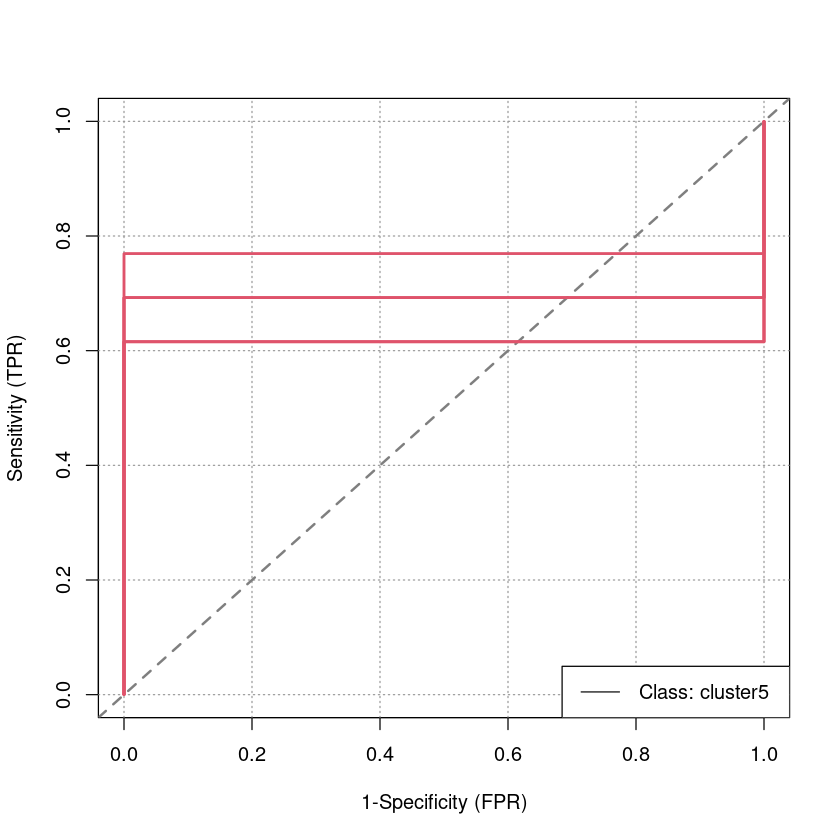

In [28]:
#ensemble_rocs(anne)
plot_roc(buffy, 1, flip=T)

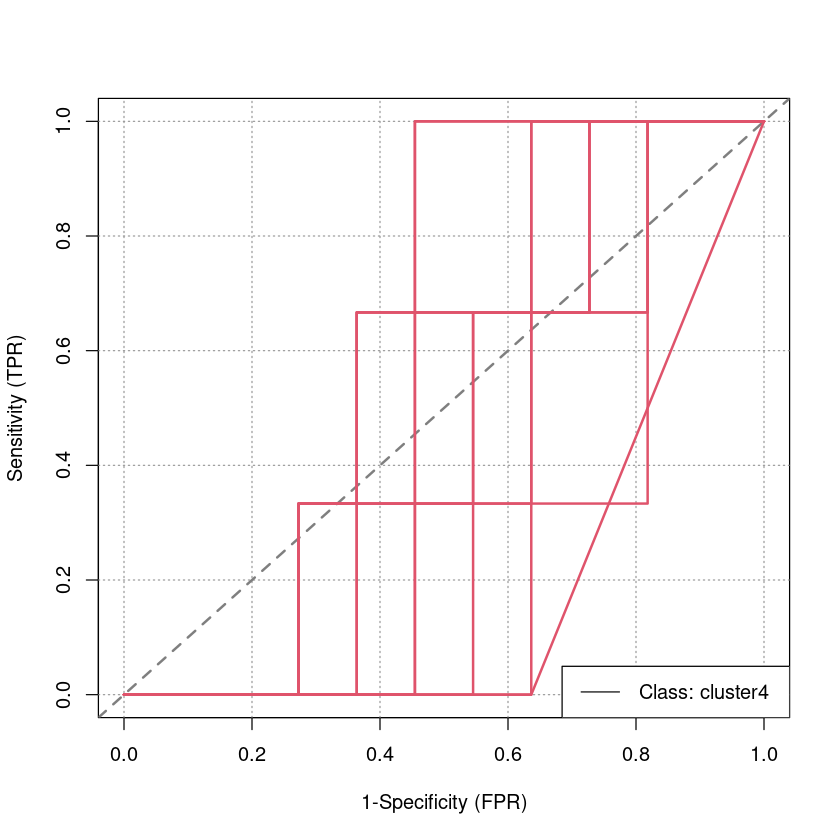

In [29]:
#ensemble_rocs(anne)
plot_roc(buffy, 2, flip=F)

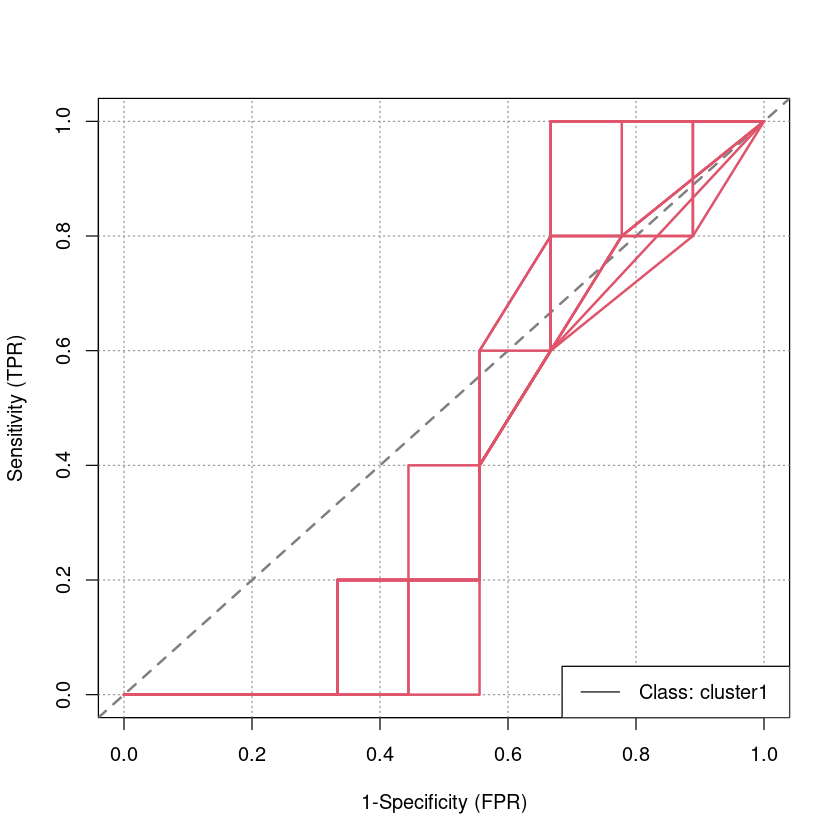

In [30]:
#ensemble_rocs(anne)
plot_roc(buffy, 3, flip=F)

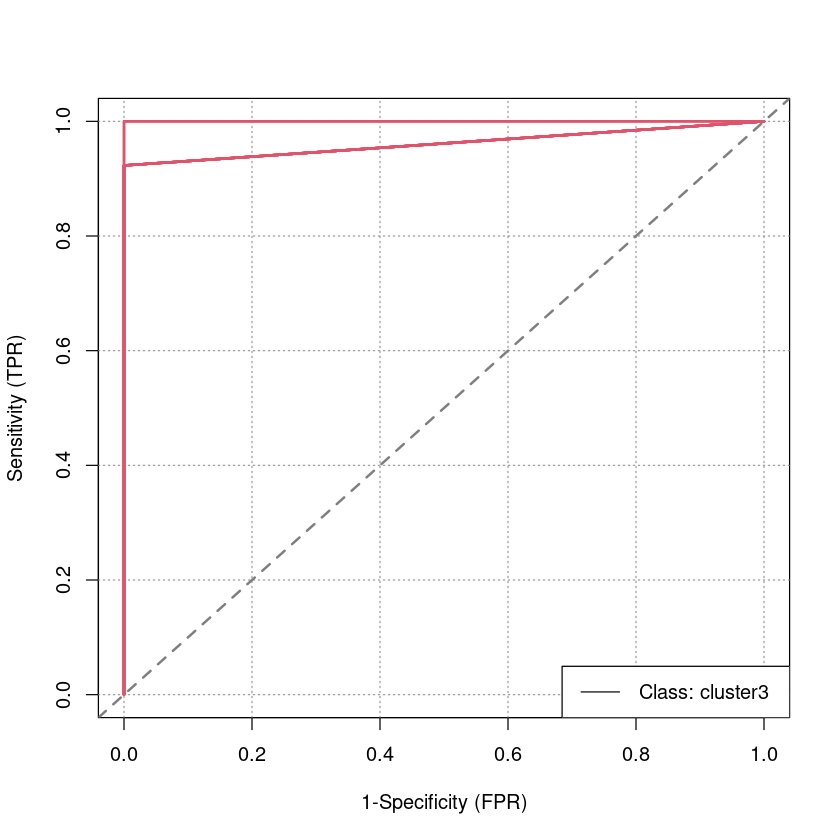

In [31]:
#ensemble_rocs(anne)
plot_roc(buffy, 4, flip=T)

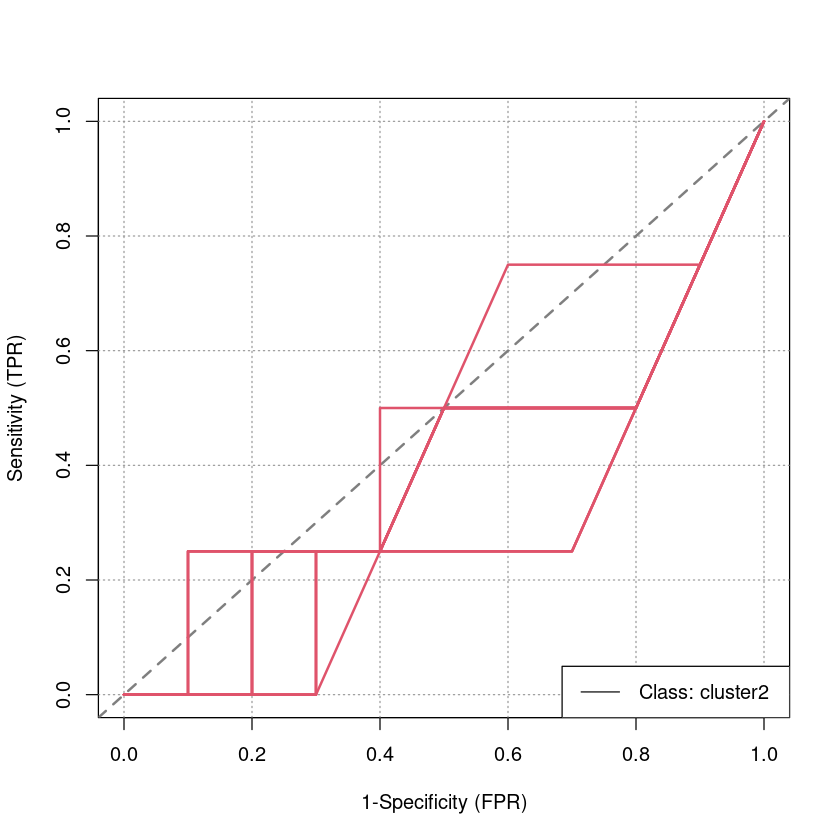

In [32]:
#ensemble_rocs(anne)
plot_roc(buffy, 5, flip=F)

In [33]:
#FIN